In [5]:
import math
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Utility

In [2]:

class BoltzmannMachine:
    def __init__(self, env_states, num_hnodes, init_W=None):
        self.rng = np.random.default_rng()
        self.env_states = env_states
        self.num_vnodes = env_states.shape[1]
        self.num_hnodes = num_hnodes
        
        self.num_nodes = self.num_vnodes + self.num_hnodes + 1 # last node is for conversion of bias to weights
        if init_W is None:
            self.W = np.zeros((self.num_nodes, self.num_nodes))
        else:
            self.W = init_W
        self.sa_sched = [(2, 20), (2, 15), (2, 12), (4, 10)] # list of tuple of `time` and `temperature`
        self.equil_time_temp = (10, 10)
        self.weight_update_magnitude = 2 # refer paper - pp. 12

        self.free_run_debug = []
        self.clamped_run_debug = []
        self.energy_change_debug = []
        self.learning_debug = []


    def get_rand_init_state(self, env_state=None):
        if env_state is not None:
            vec = np.zeros(self.num_nodes)
            vec[:self.num_vnodes] = env_state

            rand_hstate = self.rng.integers(0, 2, size=self.num_hnodes)
            vec[self.num_vnodes:-1] = rand_hstate
        else:
            vec = self.rng.integers(0, 2, size=self.num_nodes)
        
        
        vec[-1] = 1
        
        return vec
    

    def sigmoid(self, x, T):
        return 1 / (1 + math.exp(-x/T))
    

    def one_time_run(self, init_state, idxs, T):
        one_time_states = []

        # self.rng.shuffle(idxs) # this is exactly not equal to the definition of time unit in the paper.
        # for i in idxs:
        for _ in range(len(idxs)): # this follows the definition of `time`
            i = self.rng.choice(idxs, 1).item()
            energy_change = np.dot(self.W[i][:], init_state)
            self.energy_change_debug.append(energy_change)
            p_of_1 = self.sigmoid(energy_change, T)
            
            if self.rng.uniform(0, 1)<p_of_1:
                init_state[i] = 1
            else:
                init_state[i] = 0

            one_time_states.append(init_state.copy())

        return one_time_states
    
    def run(self, init_state, idxs):
        equi_states = []

        # as mentioned in the paper, network was allowed to reach equilibrium twice (pp. 11).
        for i in range(2):
            #SA
            for times, T in self.sa_sched:
                for t in range(times):
                    self.one_time_run(init_state, idxs, T)

            # now it is assumed that it has reached equilibrium, now getting the stats at equilibrium.
            for t in range(self.equil_time_temp[0]):
                equi_states.extend(self.one_time_run(init_state, idxs, self.equil_time_temp[1]))

        return equi_states


    def free_run(self):
        init_state = self.get_rand_init_state()
        
        #*********
        idxs = np.arange(self.num_vnodes + self.num_hnodes)
        #*********
        
        equi_states = self.run(init_state, idxs)    
        equi_states = np.array(equi_states)
        p_prime = (equi_states.T@equi_states)/equi_states.shape[0]

        self.free_run_debug.append(
            self.create_states_dist(equi_states)
            )

        return p_prime

    def clamped_run(self):
        equi_states = []
        debug_list = []

        for env_state in self.env_states:
            init_state = self.get_rand_init_state(env_state)
            
            #*********
            idxs = np.arange(self.num_vnodes, self.num_vnodes+self.num_hnodes)
            #*********
            
            clamped_equi_states = self.run(init_state, idxs)
            equi_states.extend(clamped_equi_states)

            debug_list.append(
                self.create_states_dist(np.array(clamped_equi_states))
            )

        equi_states = np.array(equi_states)
        p = (equi_states.T@equi_states)/equi_states.shape[0]

        self.clamped_run_debug.append(debug_list)

        return p
    
    def search(self, query):
        '''
        `-1` in the query represents the nodes which needs to be filled.
        '''
        mask = (query==-1)
        query[mask] = self.rng.uniform(0, 2, size=mask.sum())
        init_state = self.get_rand_init_state(query)
        
        idxs_free_vis = np.nonzero(mask)[0]
        idxs_hid = np.arange(self.num_vnodes, self.num_vnodes+self.num_hnodes)
        
        #*********
        idxs = np.append(idxs_free_vis, idxs_hid)
        #*********

        equi_states = self.run(init_state, idxs)
        equi_states = np.array(equi_states)
        return equi_states
        

    
    def learn(self, learning_cycles):
        W_progression = []
        for _ in tqdm(range(learning_cycles)):
            p_prime = self.free_run()
            p = self.clamped_run()
            
            #DIRECTION OF UPDATE - whether to inc or dec
            # direction = np.sign(p-p_prime)
            direction = (p-p_prime)

            np.fill_diagonal(direction, 0)

            self.learning_debug.append({
                'p': p, 
                'p_prime': p_prime, 
                'direction': direction, 
                'W': self.W
            })
            
            #WEIGHT UPDATE by fixed magnitude
            self.W = self.W + direction*self.weight_update_magnitude
            W_progression.append(self.W.copy())
            
        return W_progression
    
    def calc_energy(self, state):
        energy = -(state@(self.W@state))*0.5
        return energy
    
    def create_states_dist(self, equi_states):
        equi_dist = np.unique(equi_states, axis=0, return_counts=True)
        states, state_counts = equi_dist
        state_labels = [stringify_vec(state) for state in states]
        state_energies = [self.calc_energy(state) for state in states]

        return {
            'states': states,
            'state_labels': state_labels,
            'state_counts': state_counts,
            'state_energies': state_energies
        }
    
def parity_problem_testing(env_states, bm):
    test_res = []
    for query in env_states:
        query = query.copy()
        ans = query[2]
        query[2] = -1
        print(query, end=', ')

        res = bm.search(query)
        uniqs, uniqs_counts = np.unique(res[:, 2], return_counts=True)
        pred = uniqs[np.argmax(uniqs_counts)]
        is_correct = (pred==ans)
        print(uniqs, uniqs_counts, is_correct)
        test_res.append(is_correct)

    print(f'Result: {sum(test_res)}/4')

def plot_sigmoid(max_x, T):
    x = np.arange(-max_x, max_x)
    y = 1 / (1 + np.exp(-x/T))
    plt.plot(x, y)


def stringify_vec(vec):
    s = np.array2string(vec)
    s = s.replace('.', '').replace('[', '').replace(']', '').replace(' ', '')
    return s


def gen_free_state_dist_pdf(bm, pdf_name='free_run_plots.pdf'):
    with PdfPages(pdf_name) as pdf:
        for debug_dict in bm.free_run_debug:
            # bm_test = BoltzmannMachine(env_states, 1)
            # bm_test.W = debug_dict['W']

            num_states = debug_dict['state_counts'].shape[0]
            # if num_states < 16:
            #     new_states = all_states - set(debug_dict['state_labels'])
            #     debug_dict['state_labels'].extend(new_states)
            #     debug_dict['state_counts'].extend

            fig = plt.figure(figsize= (15, 5))    
            dist = np.array(sorted(zip(debug_dict['state_labels'], 
                                    debug_dict['state_counts'], 
                                    debug_dict['state_energies'],
                                    np.arange(num_states)), 
                                key=lambda x: x[2]))
            

            sorted_states = debug_dict['states'][dist[:, 3].astype(int)]
            ranks = get_env_states_ranks(bm.env_states, sorted_states, bm.num_vnodes)
            # print(min(ranks), max(ranks))
            print(sorted(ranks))

            sorted_energies = dist[:, 2].astype(float)
            norm = plt.Normalize(min(sorted_energies), max(sorted_energies))
            # Create a colormap
            cmap = plt.cm.viridis
            # Map the real values to colors
            colors = cmap(norm(sorted_energies))

            edgecolors = np.array(['black']*num_states)
            edgecolors[ranks] = 'g'

            plt.bar(dist[:, 0], 
                    dist[:, 1].astype(int), 
                    width=0.5, 
                    color=colors,
                    edgecolor = edgecolors,
                    linewidth = 3)
            
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            fig.colorbar(sm)

            # plt.show()
            # plt.title('Line Plot')
            # plt.xlabel('X-axis')
            # plt.ylabel('Y-axis')
            # plt.legend()
            pdf.savefig()  # Save the current figure into the PDF
            plt.close()  # Close the figure


def get_env_states_ranks(env_states, uniq_sorted_states, num_vnodes):
    ranks = []
    for env_state in env_states:
        mask = (uniq_sorted_states[:, :num_vnodes] == env_state).all(axis=1)
        ranks.extend(np.nonzero(mask)[0])

    return ranks

def gen_clamped_state_dist_pdf(bm, pdf_name='clamped_run_plots.pdf'):
    with PdfPages(pdf_name) as pdf:
        for debug_list in bm.clamped_run_debug:
            fig = plt.figure(figsize= (15, 5))    

            for i, debug_dict in enumerate(debug_list):
                dist = np.array(sorted(zip(debug_dict['state_labels'], 
                                           debug_dict['state_counts'], 
                                           debug_dict['state_energies']), 
                                      key=lambda x: x[2]))
            
                # print(dist.shape, end=', ')
            
                sorted_energies = dist[:, 2].astype(float)
                norm = plt.Normalize(min(sorted_energies), max(sorted_energies))
                # Create a colormap
                cmap = plt.cm.viridis
                # Map the real values to colors
                colors = cmap(norm(sorted_energies))

                plt.subplot(2, 2, i+1)
                plt.bar(dist[:, 0], dist[:, 1].astype(int), width=0.5, color=colors)
            
                sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
                sm.set_array([])
                fig.colorbar(sm)

            pdf.savefig()  # Save the current figure into the PDF
            plt.close()  # Close the figure

def gen_learning_plots_pdf(bm, pdf_name='learning_plots.pdf'):
    with PdfPages(pdf_name) as pdf:
        for debug_dict in bm.learning_debug:
            fig = plt.figure(figsize= (15, 5))    

            for i, item in enumerate(debug_dict.items()):
            
                # sorted_energies = dist[:, 2].astype(float)
                # norm = plt.Normalize(min(sorted_energies), max(sorted_energies))
                # Create a colormap
                # cmap = plt.cm.viridis
                # Map the real values to colors
                # colors = cmap(norm(sorted_energies))

                ax = plt.subplot(2, 2, i+1,)
                im = plt.imshow(item[1])
                plt.title(item[0])
                plt.colorbar()
            
                # sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
                # sm.set_array([])
                # fig.colorbar(sm)

            pdf.savefig()  # Save the current figure into the PDF
            plt.close()  # Close the figure

In [3]:
edgecolors = np.array(['black']*2)
edgecolors[[0, 1]] = 'y'
plt.bar(['A', 'B'], [10, 15], edgecolor = edgecolors, linewidth = 2)

NameError: name 'np' is not defined

# Exp1: Parity Problem

In [23]:
env_states = np.array([
    [0, 0, 0],
    [0, 1, 1],
    [1, 0, 1],
    [1, 1, 0]
    ])

all_states = {stringify_vec(state) for state in np.array([[0, 0, 0, 0, 1],
                    [0, 0, 0, 1, 1],
                    [0, 0, 1, 0, 1],
                    [0, 0, 1, 1, 1],
                    [0, 1, 0, 0, 1],
                    [0, 1, 0, 1, 1],
                    [0, 1, 1, 0, 1],
                    [0, 1, 1, 1, 1],
                    [1, 0, 0, 0, 1],
                    [1, 0, 0, 1, 1],
                    [1, 0, 1, 0, 1],
                    [1, 0, 1, 1, 1],
                    [1, 1, 0, 0, 1],
                    [1, 1, 0, 1, 1],
                    [1, 1, 1, 0, 1],
                    [1, 1, 1, 1, 1]])}

init_W = np.array([[ 0.     , -2.47075, -2.44625, -5.72825,  3.5965 ],
       [-2.47075,  0.     , -2.48225, -5.7075 ,  3.49025],
       [-2.44625, -2.48225,  0.     , -5.7355 ,  3.58775],
       [-5.72825, -5.7075 , -5.7355 ,  0.     ,  4.9675 ],
       [ 3.5965 ,  3.49025,  3.58775,  4.9675 ,  0.     ]])
# init_W=None

num_hid_nodes = 1
bm = BoltzmannMachine(env_states, num_hid_nodes, init_W=init_W)
bm.equil_time_temp = (1000, 0.5)
bm.weight_update_magnitude = 1

Ws = bm.learn(200)

  0%|          | 0/200 [00:00<?, ?it/s]

In [25]:
## LEARNED Correct Weights

Ws[-1]

array([[ 0.      , -2.61675 , -2.6925  , -6.348   ,  4.109875],
       [-2.61675 ,  0.      , -2.72625 , -6.317   ,  4.06425 ],
       [-2.6925  , -2.72625 ,  0.      , -6.33375 ,  4.010625],
       [-6.348   , -6.317   , -6.33375 ,  0.      ,  5.551   ],
       [ 4.109875,  4.06425 ,  4.010625,  5.551   ,  0.      ]])

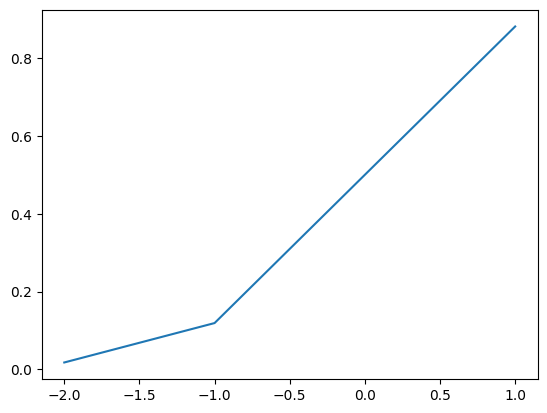

In [133]:
plot_sigmoid(2, 0.5)

In [58]:
ranks = []
for correct_env_state in env_states:
    mask = (sorted_states[:, :3] == correct_env_state).all(axis=1)
    ranks.extend(np.nonzero(mask)[0])
    # correct_count = debug_dict['state_counts'][mask].sum()

    # incorrect_env_state = correct_env_state.copy()
    # incorrect_env_state[2] = 1 if incorrect_env_state[2] == 0 else 0
    
    # mask = (debug_dict['states'][:, :3] == incorrect_env_state).all(axis=1)
    # incorrect_count = debug_dict['state_counts'][mask].sum()

    # print(correct_env_state, correct_count, incorrect_count)

min(ranks), max(ranks)

(4, 14)

In [24]:
with PdfPages('ws_plots.pdf') as pdf:
    for W_ in Ws:
        plt.hist(W_.flatten())
        pdf.savefig()
        plt.close()


gen_free_state_dist_pdf(bm)
gen_clamped_state_dist_pdf(bm)
gen_learning_plots_pdf(bm)


print('PDFs generated!')

[0, 1, 2, 3, 11]
[0, 1, 2, 3]


C:\Users\Acer\AppData\Local\Temp\ipykernel_3580\3842491127.py:258: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(sm)


[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3, 11]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3, 11]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3, 11]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3, 11]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3, 11]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3, 11]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3, 11]
[0, 1, 2, 3, 11]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3, 11]
[0, 1, 2, 3, 11]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3

C:\Users\Acer\AppData\Local\Temp\ipykernel_3580\3842491127.py:302: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(sm)


PDFs generated!


In [134]:
for i in range(50):
    # print(bm.learning_debug[i]['p'])
    # print(bm.learning_debug[i]['p_prime'])
    print(bm.learning_debug[i]['W'])
    print('-'*30)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
------------------------------
[[ 0.        0.0016    0.00105   0.006175  0.003525]
 [ 0.0016    0.       -0.00375   0.       -0.00985 ]
 [ 0.00105  -0.00375   0.        0.009925 -0.00285 ]
 [ 0.006175  0.        0.009925  0.        0.014475]
 [ 0.003525 -0.00985  -0.00285   0.014475  0.      ]]
------------------------------
[[ 0.       -0.009    -0.017675 -0.00085  -0.017125]
 [-0.009     0.       -0.008125  0.001175 -0.00605 ]
 [-0.017675 -0.008125  0.        0.0043   -0.0126  ]
 [-0.00085   0.001175  0.0043    0.        0.014725]
 [-0.017125 -0.00605  -0.0126    0.014725  0.      ]]
------------------------------
[[ 0.        0.00535   0.008925  0.011925  0.0117  ]
 [ 0.00535   0.        0.003825  0.001575 -0.005925]
 [ 0.008925  0.003825  0.        0.011425  0.0086  ]
 [ 0.011925  0.001575  0.011425  0.        0.004825]
 [ 0.0117   -0.005925  0.0086    0.004825  0.      ]]
------------------

In [12]:
# testing
for i, W_ in enumerate(Ws[-5:]):
    print(f'#{i}')
    bm_test = BoltzmannMachine(env_states, 1)
    bm_test.equil_time_temp = (10000, 3)
    bm_test.W = W_
    parity_problem_testing(env_states, bm_test)
    print('-'*40)

#0
[ 0  0 -1], [0. 1.] [19859 20141] False
[ 0  1 -1], [0. 1.] [26404 13596] False
[ 1  0 -1], [0. 1.] [20045 19955] False
[ 1  1 -1], [0. 1.] [26216 13784] True
Result: 1/4
----------------------------------------
#1
[ 0  0 -1], [0. 1.] [16235 23765] False
[ 0  1 -1], [0. 1.] [19452 20548] True
[ 1  0 -1], [0. 1.] [12833 27167] True
[ 1  1 -1], [0. 1.] [16415 23585] False
Result: 2/4
----------------------------------------
#2
[ 0  0 -1], [0. 1.] [19960 20040] False
[ 0  1 -1], [0. 1.] [26507 13493] False
[ 1  0 -1], [0. 1.] [19873 20127] True
[ 1  1 -1], [0. 1.] [26493 13507] True
Result: 2/4
----------------------------------------
#3
[ 0  0 -1], [0. 1.] [16541 23459] False
[ 0  1 -1], [0. 1.] [19664 20336] True
[ 1  0 -1], [0. 1.] [13151 26849] True
[ 1  1 -1], [0. 1.] [16281 23719] False
Result: 2/4
----------------------------------------
#4
[ 0  0 -1], [0. 1.] [19928 20072] False
[ 0  1 -1], [0. 1.] [26723 13277] False
[ 1  0 -1], [0. 1.] [19903 20097] True
[ 1  1 -1], [0. 1.] [

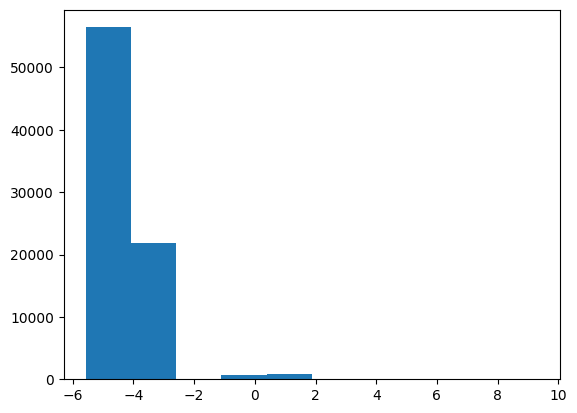

[0, 1, 2, 3, 11, 12, 13, 14]
PDF created!
[ 0  0 -1], 

C:\Users\Acer\AppData\Local\Temp\ipykernel_3580\3842491127.py:258: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(sm)


[0. 1.] [23319 16681] True
[ 0  1 -1], [0. 1.] [18392 21608] True
[ 1  0 -1], [0. 1.] [18095 21905] True
[ 1  1 -1], [0. 1.] [27134 12866] True
Result: 4/4
[ 0  0 -1], [0. 1.] [23067 16933] True
[ 0  1 -1], [0. 1.] [18567 21433] True
[ 1  0 -1], [0. 1.] [18679 21321] True
[ 1  1 -1], [0. 1.] [27256 12744] True
Result: 4/4
[ 0  0 -1], [0. 1.] [23210 16790] True
[ 0  1 -1], [0. 1.] [18152 21848] True
[ 1  0 -1], [0. 1.] [18028 21972] True
[ 1  1 -1], [0. 1.] [26736 13264] True
Result: 4/4
[ 0  0 -1], [0. 1.] [23269 16731] True
[ 0  1 -1], [0. 1.] [19091 20909] True
[ 1  0 -1], [0. 1.] [18488 21512] True
[ 1  1 -1], [0. 1.] [26858 13142] True
Result: 4/4
[ 0  0 -1], [0. 1.] [23104 16896] True
[ 0  1 -1], [0. 1.] [18767 21233] True
[ 1  0 -1], [0. 1.] [17921 22079] True
[ 1  1 -1], [0. 1.] [27103 12897] True
Result: 4/4


In [26]:
# Manual GT
# gt_W = np.array([
#     [0, 0, 1, 1, 0],
#     [0, 0, 1, 1, 0],
#     [1, 1, 0, -2, -0.5],
#     [1, 1, -2, 0, -1.1],
#     [0, 0, -0.5, -1.1, 0]
# ])
# T = 3

# GT from paper
# gt_W = np.array([
#     [0, -5, 5, 11, -3],
#     [-5, 0, 5, 11, -3],
#     [5, 5, 0, -11, -2],
#     [11, 11, -11, 0, -11],
#     [-3, -3, -2, -11, 0]
# ])
# T = 3


# learned weights-1
# gt_W = np.array([[ 0.      , -2.957825, -3.056925, -7.00185 ,  4.597   ],
#                  [-2.957825,  0.      , -2.92985 , -6.99895 ,  4.72495 ],
#                  [-3.056925, -2.92985 ,  0.      , -7.009375,  4.61545 ],
#                  [-7.00185 , -6.99895 , -7.009375,  0.      ,  6.130025],
#                  [ 4.597   ,  4.72495 ,  4.61545 ,  6.130025,  0.      ]])
# T = 2

# learned weights-2
gt_W = np.array([[ 0.      , -2.61675 , -2.6925  , -6.348   ,  4.109875],
                [-2.61675 ,  0.      , -2.72625 , -6.317   ,  4.06425 ],
                [-2.6925  , -2.72625 ,  0.      , -6.33375 ,  4.010625],
                [-6.348   , -6.317   , -6.33375 ,  0.      ,  5.551   ],
                [ 4.109875,  4.06425 ,  4.010625,  5.551   ,  0.      ]])
T=2


gt_bm = BoltzmannMachine(env_states, 1)
gt_bm.W = gt_W
gt_bm.equil_time_temp = (10000, T)

# parity_problem_testing(env_states, gt_bm)


#------ energy distribution
query = np.ones(3)*-1
equi_states = gt_bm.search(query)

energies = np.array([gt_bm.calc_energy(state) for state in equi_states])
# np.unique(energies, return_counts=True)
plt.hist(energies)
plt.show()

# equi_dist = np.unique(equi_states, axis=0, return_counts=True)
# states, state_counts = equi_dist

# for state, count in zip(states, state_counts):
#     print(state, count, gt_bm.calc_energy(state))

gt_bm.free_run_debug = [gt_bm.create_states_dist(equi_states)]
gen_free_state_dist_pdf(gt_bm, 'gt_bm_plots.pdf')
print('PDF created!')

for _ in range(5):
    parity_problem_testing(env_states, gt_bm)

In [68]:
gt_bm.free_run_debug

[]

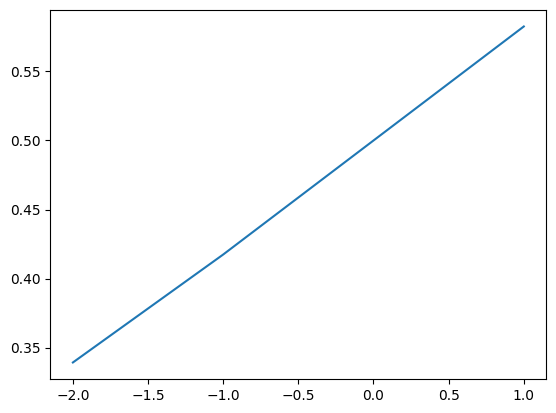

In [9]:
plot_sigmoid(2, 3)